<a href="https://colab.research.google.com/github/yutan0565/colab_git/blob/main/MobileNet_V3_Small_%EC%98%88%EC%8B%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 기본 모델 형성




In [71]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import tempfile

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger



In [72]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = tf.keras.datasets.cifar10.load_data()

"""
print(raw_train_x.shape)
print(raw_test_x.shape)
print(raw_train_y.shape)
print(raw_test_y.shape)
"""

'\nprint(raw_train_x.shape)\nprint(raw_test_x.shape)\nprint(raw_train_y.shape)\nprint(raw_test_y.shape)\n'

In [73]:
# float을 넣을거면 0~1 사이 값으로 바꿔야함
train_x = raw_train_x[:45000].astype(np.float32)/255.0
valid_x = raw_train_x[45000:].astype(np.float32)/255.0
test_x = raw_test_x.astype(np.float32)/255.0


train_y = raw_train_y[:45000]
valid_y = raw_train_y[45000:]
test_y = raw_test_y
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


"""
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)
print(train_y.shape)
print(valid_y.shape)
print(test_y.shape)

def show_sample(i):
  print(raw_train_y[i][0], labels[raw_train_y[i][0]])
  plt.imshow(raw_train_x[i])
  plt.show()

for i in [2, 10, 12, 14]:
  show_sample(i)
"""

'\nprint(train_x.shape)\nprint(valid_x.shape)\nprint(test_x.shape)\nprint(train_y.shape)\nprint(valid_y.shape)\nprint(test_y.shape)\n\ndef show_sample(i):\n  print(raw_train_y[i][0], labels[raw_train_y[i][0]])\n  plt.imshow(raw_train_x[i])\n  plt.show()\n\nfor i in [2, 10, 12, 14]:\n  show_sample(i)\n'

In [74]:
mobile = MobileNetV3Small(             # weights = 'imagenet',  그냥 초기화 하는거면, 이거 지우기
                            include_top = False,
                            input_shape=(32,32,3)
                            )

# vgg conv 구조만 사용하고 마지막 FC layer는 다른거 사용

fc_layer = keras.Sequential([
                             layers.Flatten(),
                             layers.Dense(512, activation = 'relu'),
                             layers.Dense(512, activation = 'relu'),
                             layers.Dense(10, activation = "sigmoid")
                             ])

model = keras.Sequential([mobile,
                          fc_layer
                          ])

# mobile.summary()
# fc_layer.summary()


In [75]:
es = EarlyStopping(patience=20) 
mc = ModelCheckpoint("/check_point.h5", save_best_only=True) 
reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss',
                               factor=0.1, 
                               patience=5
                               ) 
csvlogger = CSVLogger("model_log.log") 


# optimizer, loss 함수를 정의하고,  학습 준비를 한다,  metrics 는 어떤 일이 발생하는지 보여줄 것들
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])



# 한번에 몇개의 데이터 학습하고 가중치 갱신할지 
model.fit(train_x, train_y,
          epochs=50,
          verbose=1,
          batch_size=128,
          #validation_split = 0.1
          validation_data = (valid_x, valid_y),
          callbacks = [es, mc, reduce_lr , csvlogger]
          )

# call back 참고 : https://deep-deep-deep.tistory.com/1 들어가면 여러 옵션들이 나옴

Epoch 1/50
352/352 [==============================] - 78s 206ms/step - loss: 1.8131 - accuracy: 0.3436 - val_loss: 3.1048 - val_accuracy: 0.0986 - lr: 0.0010
Epoch 2/50
352/352 [==============================] - 72s 204ms/step - loss: 1.3931 - accuracy: 0.4959 - val_loss: 2.6037 - val_accuracy: 0.0988 - lr: 0.0010
Epoch 3/50
352/352 [==============================] - 73s 206ms/step - loss: 1.2113 - accuracy: 0.5678 - val_loss: 2.8129 - val_accuracy: 0.0950 - lr: 0.0010
Epoch 4/50
352/352 [==============================] - 70s 200ms/step - loss: 1.1008 - accuracy: 0.6059 - val_loss: 2.9072 - val_accuracy: 0.0978 - lr: 0.0010
Epoch 5/50
352/352 [==============================] - 71s 202ms/step - loss: 1.0093 - accuracy: 0.6422 - val_loss: 3.4657 - val_accuracy: 0.0978 - lr: 0.0010
Epoch 6/50
352/352 [==============================] - 80s 228ms/step - loss: 0.9373 - accuracy: 0.6663 - val_loss: 2.5185 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 7/50
352/352 [==============================] 

In [76]:
loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

313/313 [==============================] - 6s 18ms/step - loss: 1.9111 - accuracy: 0.6372
loss= 1.9110753536224365
acc= 0.6371999979019165
[3 8 1 ... 5 0 7]


## int_8 Quantization 진행




In [77]:
# 구조까지 들어가 있는거
#model_load = tf.keras.models.load_model('saved_model/my_model')

In [78]:
# input 에 대해서 변수 설정
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_x).batch(1).take(100):
    yield [input_value]

In [79]:
# int 8 로 quantization 진행하기
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpkt9c72tp/assets


INFO:tensorflow:Assets written to: /tmp/tmpkt9c72tp/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [80]:
# 그냥 파일 형태만 tflite로 변환 (float 형태임)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpaxkiqzoz/assets


INFO:tensorflow:Assets written to: /tmp/tmpaxkiqzoz/assets


In [81]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [82]:
# 모델 저장 해주는 과정
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mobile_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mobile_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mobiile_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

1796048

In [83]:
# tensorlffow lite 모델 실행 해보기

In [84]:
def run_tflite_model(tflite_file, test_image_indices):
  global test_x

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_x[test_image_index]
    test_label = test_y[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [85]:
def evaluate_model(tflite_file, model_type):
  global test_x
  global test_y

  test_image_indices = range(test_x.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_y== predictions) * 100) / len(test_x)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_x)))

In [86]:
evaluate_model(tflite_model_file, model_type="Float")
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Float model accuracy is 100000.0000% (Number of test samples=10000)
Quantized model accuracy is 100000.0000% (Number of test samples=10000)


In [87]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_x[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_y[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

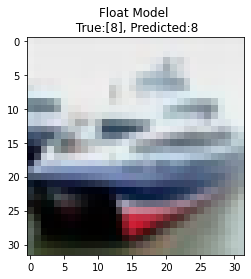

In [88]:
test_model(tflite_model_file, test_image_index, model_type="Float")

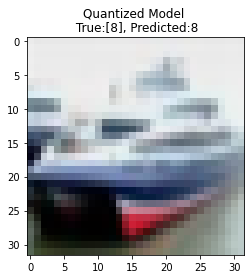

In [89]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

## int_16 Quantization 진행




## Pruning 진행



In [90]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 237 kB 5.1 MB/s 


In [91]:
_, baseline_model_accuracy = model.evaluate(
    test_x, test_y, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.6371999979019165


NameError: ignored